### **Deutsch–Jozsa Algorithm**

The Deutsch–Jozsa algorithm determines whether a hidden function $f: \{0,1\}^n \to \{0,1\}$ is constant or balanced.

<br>

---


**1. Introduction**

**Input:** a function $f: \{0,1\}^n \to \{0,1\}$

<br>

**Promise:** The function $f$ is guaranteed to be one of two types:

* **Constant:** $$f(x) = c \quad \forall x$$ (where $c$ is always 0 or always 1)

* **Balanced:** $$f(x) = 0 \text{ for half of inputs}$$
    $$f(x) = 1 \text{ for the other half}$$

<br>

**Goal:** Determine whether $f$ is **Constant** or **Balanced**

<br>

---

<br>

**Quantum vs Classical**


 - Classical      =>      $2^{n-1} + 1$ calls (worst case for 100% certainty)

<br>

 - Quantum         =>      1 single oracle call

---

In [150]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit_aer import AerSimulator

num_of_qubits = 5


<br>

**2. Build Deutsch–Jozsa Oracle**

The oracle must implement the transformation:
$$|x, y\rangle \to |x, \, y \oplus f(x)\rangle$$

We randomly generate a function that satisfies the Deutsch–Jozsa promise:

 - Constant Case (50% chance)
    * $f(x) = 0$ => do nothing!
    * $f(x) = 1$ => apply $X$ gate to the ancilla qubit.

<br>

- Balanced Case (50% chance)
    1.  Randomly choose half of all possible input bitstrings where $f(x) = 1$.
    2.  For each such input:
        * Temporarily transform that basis state using $X$ gates.
        * Apply a multi-controlled NOT to flip the ancilla.
        * Undo the temporary $X$ gates.

<br>

---

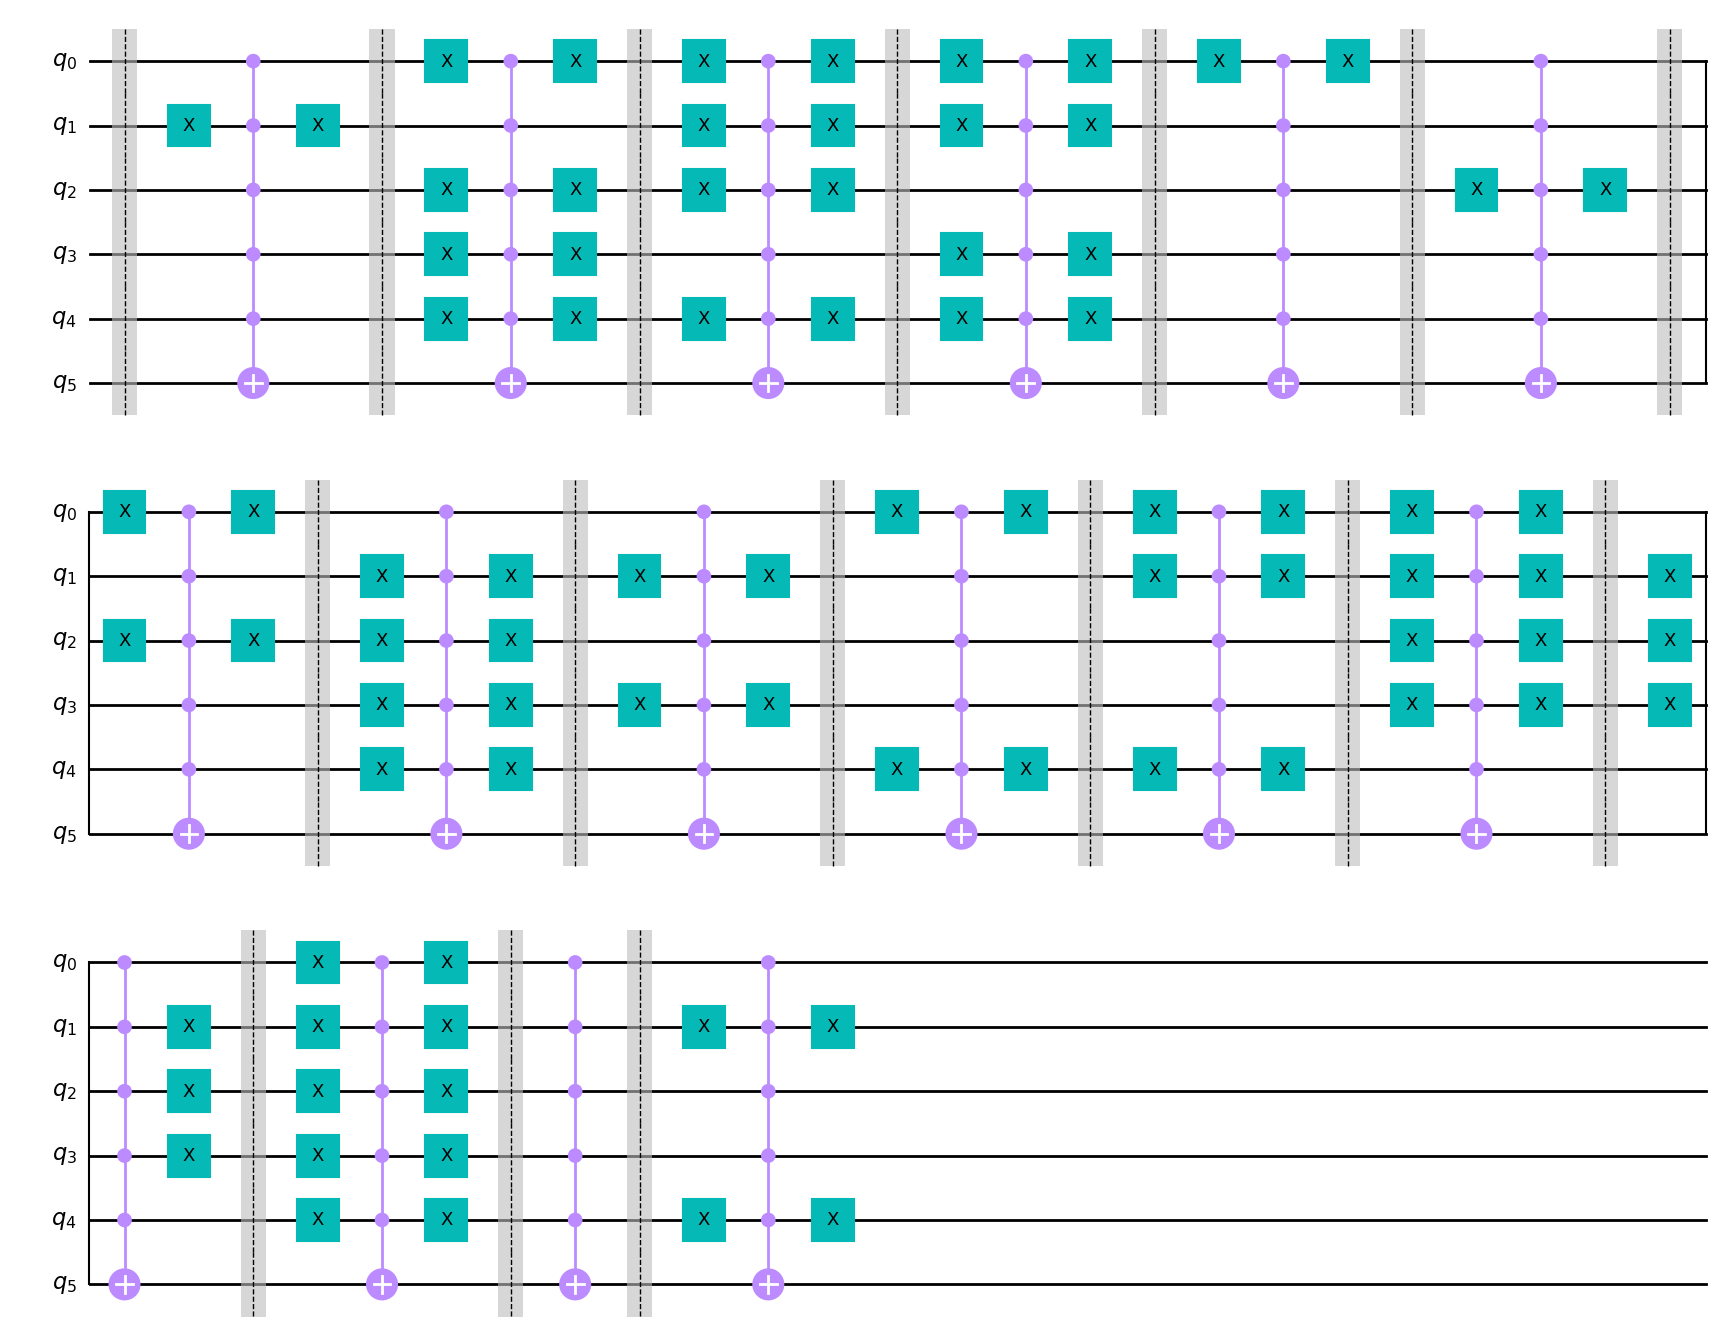

In [151]:

def build_dj_oracle(n):
    qc = QuantumCircuit(n + 1)

    is_balanced = np.random.randint(0, 2)
    if not is_balanced:
        # --- CONSTANT CASE ---
        if np.random.randint(0, 2):
            qc.x(n)

    else:
        # --- BALANCED CASE ---
        on_states = np.random.choice(
            range(2 ** n),
            2 ** n // 2,
            replace=False,
        )

        # Helper to flip bits
        def encode_state(circuit, bitstring):
            for qubit, bit in enumerate(reversed(bitstring)):
                if bit == "1":
                    circuit.x(qubit)
            return circuit

        for state in on_states:
            qc.barrier()
            bitstring = f"{state:0{n}b}"
            qc = encode_state(qc, bitstring)
            qc.mcx(list(range(n)), n)
            qc = encode_state(qc, bitstring)

    return qc

dj_oracle = build_dj_oracle(num_of_qubits)
dj_oracle.draw('mpl')



<br>

**3. Deutsch–Jozsa circuit construction**

<br>

---

In [152]:

def dj_circuit(oracle, n):
    qc = QuantumCircuit(n + 1, n)

    # Step 1: prepare ancilla in |1>
    qc.x(n)

    # Step 2: apply Hadamards to all qubits
    qc.h(range(n + 1))
    qc.barrier()

    # Step 3: apply the oracle
    qc.compose(oracle, inplace=True)
    qc.barrier()

    # Step 4: apply Hadamard to input qubits
    qc.h(range(n))
    qc.barrier()

    # Step 5: measure input qubits
    qc.measure(range(n), range(n))

    return qc



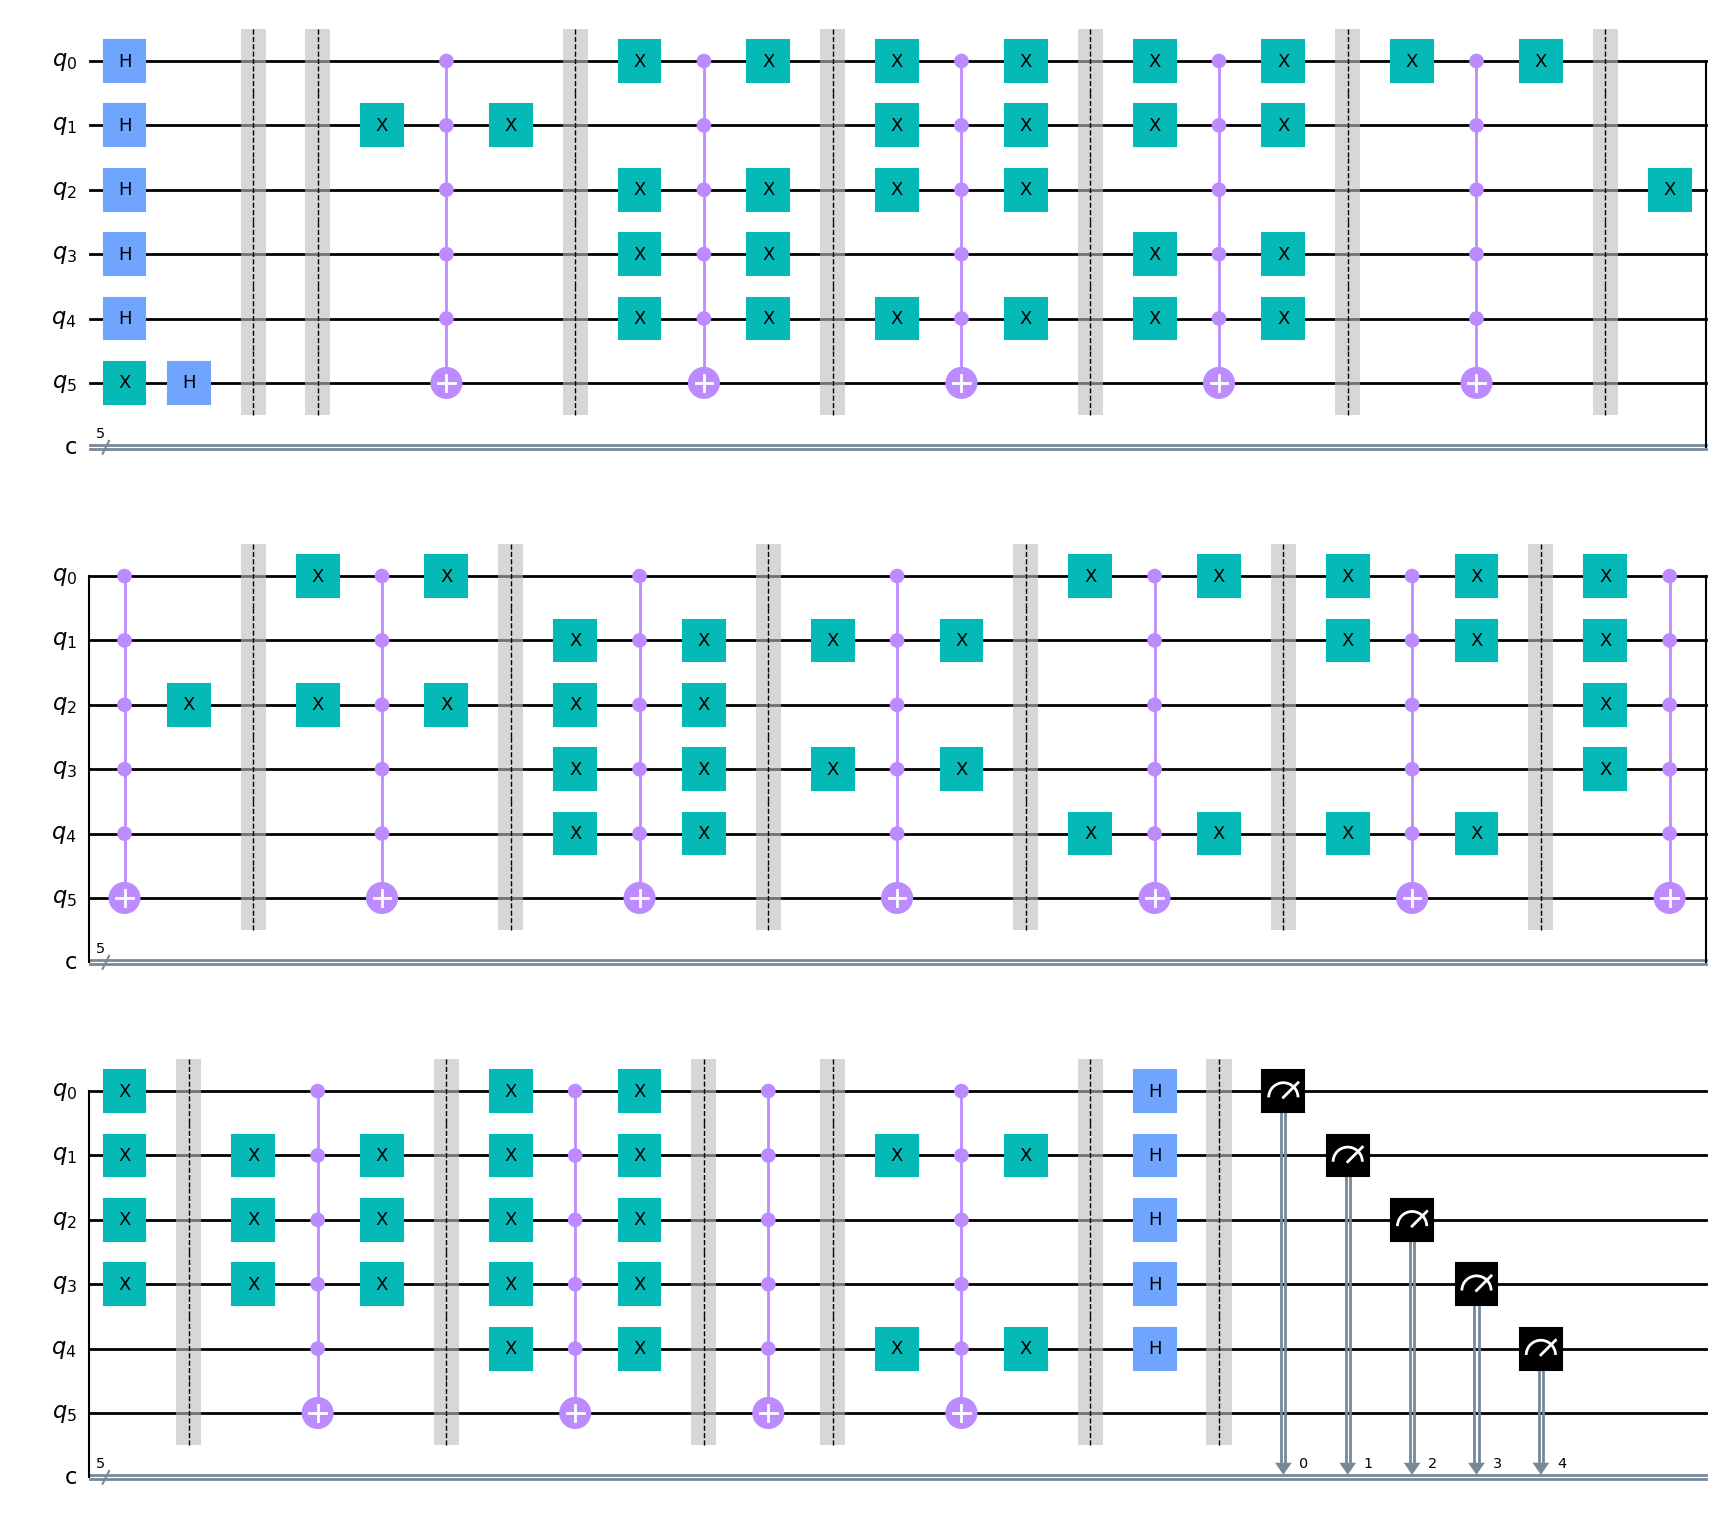

In [153]:
qc = dj_circuit(dj_oracle, num_of_qubits)
qc.draw("mpl")


<br>

**4. Simulation**

After measurement:
 - All input qubits = 0     =>  CONSTANT!
 - Any input qubit = 1      =>  BALANCED!

<br>

---

In [154]:

sim = AerSimulator()

compiled_circuit = transpile(qc, sim)
job = sim.run(compiled_circuit, shots=1024)

result = job.result()
counts = result.get_counts()

measured_bitstring = max(counts, key=counts.get)
print(f"Measured string: {measured_bitstring}")

if int(measured_bitstring, 2) == 0:
    print("Result: Constant")
else:
    print("Result: Balanced")





Measured string: 10001
Result: Balanced
